In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def ImportAndClean(file:str,year:int):
    try:
        if 'NREL' in file:
            #Read in weather file: converting time columns to DateTime, fixing timezone and angle, and selecting used columns
            df = pd.read_csv(file,header=2,usecols=[0,1,2,3,4,20,21])
            df['Date'] = pd.to_datetime(df[['Year','Month','Day','Hour','Minute']])
            df = df.set_index('Date')
            #df.index = df.index+pd.Timedelta(hours=-7)
            df['Solar Zenith Angle'] *= np.pi/180
            df = df.drop(columns=['Year','Month','Day','Hour','Minute'])
            df.index.names = ['Date']
            return df
        elif 'environment' in file:
            #Read in environment file: converting time columns to DateTime and selecting used columns
            df = pd.read_csv(file,index_col=[0],usecols=[0,1,9])
            df = df.set_index(pd.to_datetime(df.index))
            df = df.rename(columns={df.columns[0]: "Ambient Temperature",df.columns[1]: "Wind Sensor"})
            df['Ambient Temperature'] += 273
            df.dropna(inplace=True)
            df.index.names = ['Date']
            return df[df.index.year == year]
        elif 'power' in file:
            #Read in power file: converting time columns to DateTime, selecting power columns, and returning energy column
            df = pd.read_csv(file,index_col=0,usecols=[0,9,10])
            df = df.set_index(pd.to_datetime(df.index))
            df['Power'] = df.iloc[:,[0,1]].mean(axis=1)
            #Energy ~ Power*Time
            df['Energy'] = df['Power']/12
            df = df[['Energy']].dropna(axis=0)
            df.index.names = ['Date']
            return df.iloc[df.index.year == year]
            
    except Exception as e:
        print(f'Error: {e}')

In [3]:
Weather22 = ImportAndClean("../data/NREL_Weather/1000190_40.38_-104.55_2022.csv",2022).tz_localize(tz='UTC',ambiguous='NaT')
Energy22 = ImportAndClean("../data/Data_9068/9068_ac_power_data_2022.csv",2022).tz_localize(tz='America/Denver',ambiguous='NaT')
SolarData22 = pd.merge(Weather22,Energy22,left_index=True,right_index=True,how="inner")

Weather24 = ImportAndClean("../data/NREL_Weather/1000190_40.38_-104.55_2024.csv",2024)
Weather24.index = Weather24.index+pd.Timedelta(hours = 7)
Weather24 = Weather24.tz_localize(tz='UTC',ambiguous='infer')
Energy24 = ImportAndClean("../data/Data_9068/9068_ac_power_data_20240101_20250430.csv",2024).tz_localize(tz='America/Denver',ambiguous='NaT')
SolarData24 = pd.merge(Weather24,Energy24,left_index=True,right_index=True,how="inner")

In [5]:
CloudCoverage = pd.read_csv('../data/total_cloud_cover_UTC.csv',parse_dates=[0],index_col=0)

In [6]:
aggregation = {col:'mean' for col in SolarData22.columns}
aggregation.update({'Energy':'sum'})

SolarData22 = SolarData22.resample('h').agg(aggregation)
SolarData24 = SolarData24.resample('h').agg(aggregation)

SolarData22 = pd.merge(SolarData22,CloudCoverage,left_index=True,right_index=True,how="inner")
SolarData24 = pd.merge(SolarData24,CloudCoverage,left_index=True,right_index=True,how="inner")

In [7]:
SolarDataDay22 = SolarData22[SolarData22['Solar Zenith Angle']<np.pi/2]
SolarDataDay24 = SolarData24[SolarData24['Solar Zenith Angle']<np.pi/2]

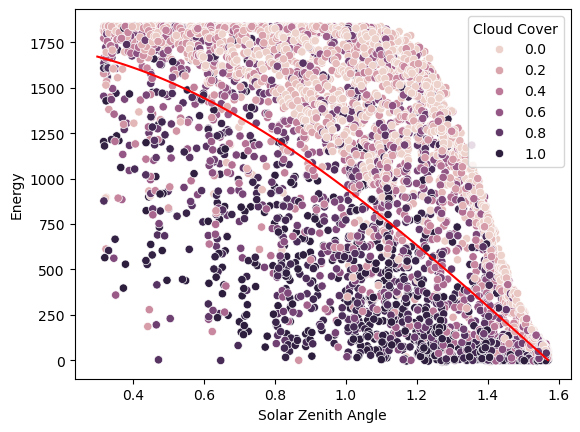

In [8]:
SolarDataDay22r = SolarDataDay22.copy()
SolarDataDay22r = SolarDataDay22r.rename(columns={'tcc':'Cloud Cover'})
sns.scatterplot(SolarDataDay22r,x='Solar Zenith Angle',y='Energy',hue='Cloud Cover')
xs = np.linspace(0.3,1.57,100)
ys = 1750*np.cos(xs)
plt.plot(xs,ys,'r')
plt.show()

In [9]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

tscv = TimeSeriesSplit(n_splits = 10)

baseline1 = DummyRegressor(strategy='mean')

baseline1_x = SolarDataDay22[['Solar Zenith Angle']].copy()
baseline1_y = SolarDataDay22[['Energy']].copy()

baseline1.fit(baseline1_x,baseline1_y)
baseline1_y['Prediction'] = baseline1.predict(baseline1_x)

print("RMSE:", root_mean_squared_error(baseline1_y['Prediction'],baseline1_y['Energy']))
print("r2:", r2_score(baseline1_y['Prediction'],baseline1_y['Energy']))

RMSE: 641.6252981124326
r2: 0.0


RMSE: 614.8737782027881
r2: -2.925173108819281e+31


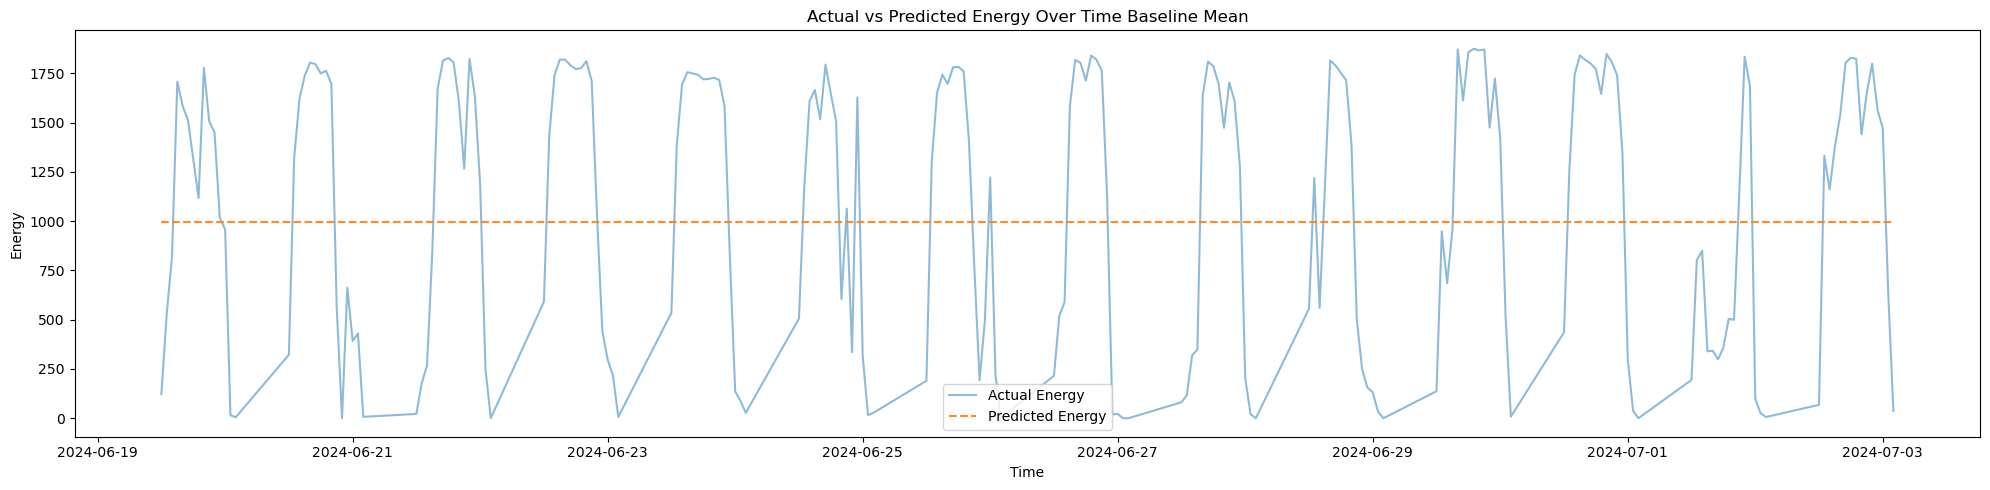

In [10]:
baseline1_x24 = SolarDataDay24[['Solar Zenith Angle']].copy()
baseline1_y24 = SolarDataDay24[['Energy']].copy()

baseline1_y24['Prediction'] = baseline1.predict(baseline1_x24)

days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

print("RMSE:", root_mean_squared_error(baseline1_y24['Prediction'],baseline1_y24['Energy']))
print("r2:", r2_score(baseline1_y24['Prediction'],baseline1_y24['Energy']))

plt.figure(figsize=(20, 5))
plt.plot(SolarDataDay24.loc[random_start24:end_day24].index, baseline1_y24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(SolarDataDay24.loc[random_start24:end_day24].index, baseline1_y24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time Baseline Mean")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
X_0_22 = SolarDataDay22[['Solar Zenith Angle']]
y_0_22 = SolarDataDay22['Energy']

model_0 = LinearRegression()

rmse_scores0 = cross_val_score(model_0, X_0_22, y_0_22, cv=tscv, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -rmse_scores0)
print("Average RMSE:", -rmse_scores0.mean())

r2_scores0 = cross_val_score(model_0, X_0_22, y_0_22, cv=tscv, scoring='r2')

#print("r2 scores:", r2_scores0)
print("Average r2:", r2_scores0.mean())

Average RMSE: 489.73301774236495
Average r2: 0.364963634567497


RMSE: 451.35374278737396
r2: 0.45176063459947713


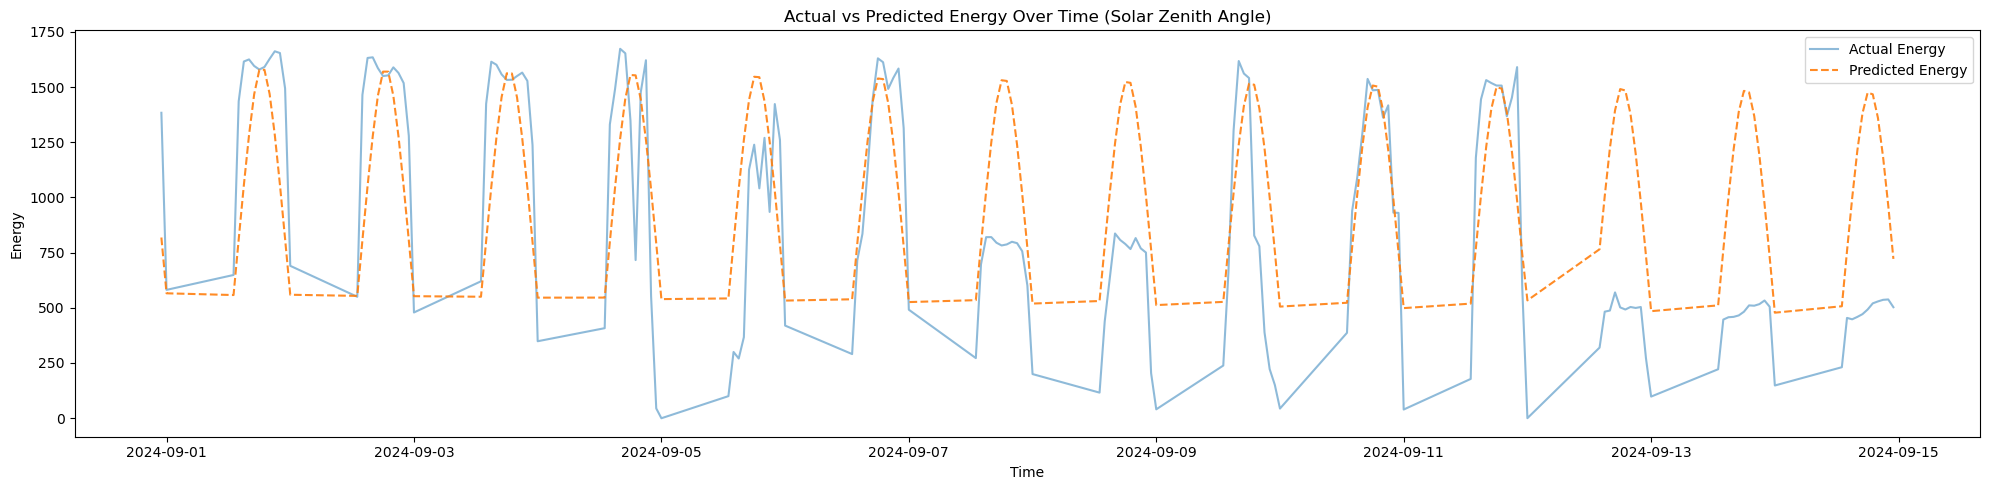

In [12]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_0.fit(X_0_22,y_0_22)

X_0_24 = SolarDataDay24[['Solar Zenith Angle']]
y_0_24 = SolarDataDay24[['Energy']].copy()

y_0_24['Prediction'] = model_0.predict(X_0_24)

print('RMSE:',root_mean_squared_error(y_0_24.iloc[:,0],y_0_24.iloc[:,1]))
print('r2:',r2_score(y_0_24.iloc[:,0],y_0_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(y_0_24.loc[random_start24:end_day24].index, y_0_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(y_0_24.loc[random_start24:end_day24].index, y_0_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Solar Zenith Angle)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
model_1 = Pipeline(steps=[
    ('feature_change', ColumnTransformer(transformers=[('cos',FunctionTransformer(np.cos),['Solar Zenith Angle'])],remainder='passthrough')),
    ('regression', LinearRegression(n_jobs=-1))
])
X_1_22 = SolarDataDay22[['Solar Zenith Angle']]
y_1_22 = SolarDataDay22['Energy']

rmse_scores1 = cross_val_score(model_1, X_1_22, y_1_22, cv=tscv, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -rmse_scores1)
print("Average RMSE:", -rmse_scores1.mean())

r2_scores1 = cross_val_score(model_1, X_1_22, y_1_22, cv=tscv, scoring='r2')

#print("r2 scores:", r2_scores1)
print("Average r2:", r2_scores1.mean())

Average RMSE: 475.2057268361121
Average r2: 0.4020218963575646


RMSE: 451.35374278737396
r2: 0.45176063459947713


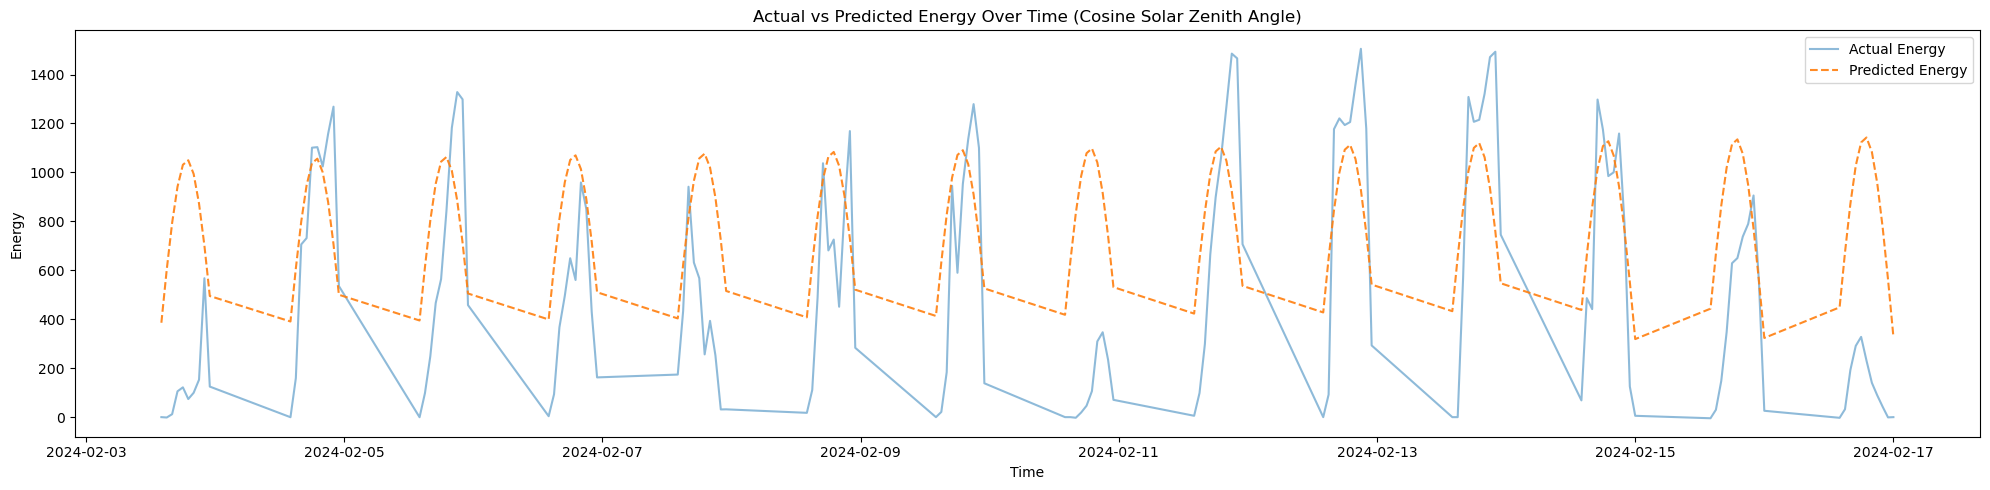

In [14]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_1.fit(X_1_22,y_1_22)

X_1_24 = SolarDataDay24[['Solar Zenith Angle']]
y_1_24 = SolarDataDay24[['Energy']].copy()

y_1_24['Prediction'] = model_0.predict(X_1_24)

print('RMSE:',root_mean_squared_error(y_1_24.iloc[:,0],y_1_24.iloc[:,1]))
print('r2:',r2_score(y_1_24.iloc[:,0],y_1_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(y_1_24.loc[random_start24:end_day24].index, y_1_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(y_1_24.loc[random_start24:end_day24].index, y_1_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Cosine Solar Zenith Angle)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
model_2 = LinearRegression(n_jobs=-1)

X_2_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity']]
y_2_22 = SolarDataDay22['Energy']

rmse_scores2 = cross_val_score(model_2, X_2_22, y_2_22, cv=tscv, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -rmse_scores2)
print("Average RMSE:", -rmse_scores2.mean())

r2_scores2 = cross_val_score(model_2, X_2_22, y_2_22, cv=tscv, scoring='r2')

#print("r2 scores:", r2_scores2)
print("Average r2:", r2_scores2.mean())

Average RMSE: 451.4430977049552
Average r2: 0.46286616229943733


RMSE: 420.9213339618809
r2: 0.5231980795508214


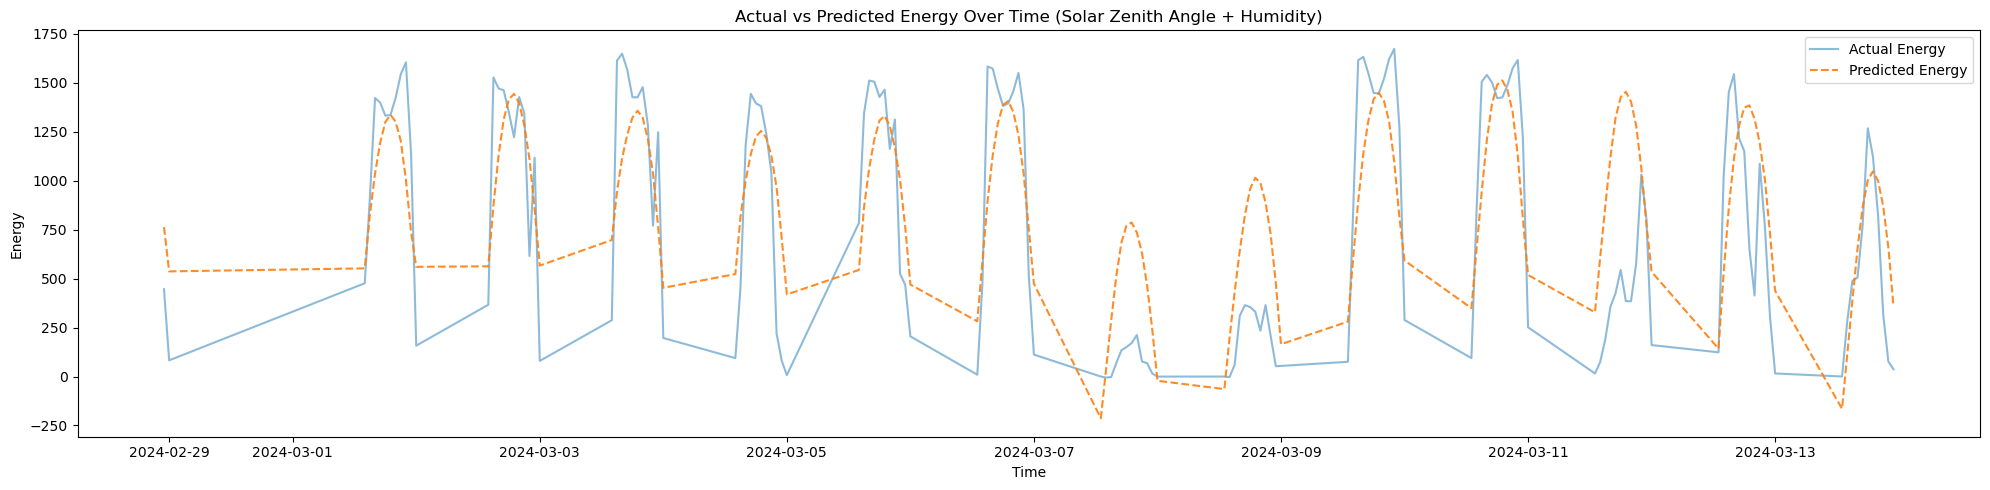

In [16]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_2.fit(X_2_22,y_2_22)

X_2_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity']]
y_2_24 = SolarDataDay24[['Energy']].copy()

y_2_24['Prediction'] = model_2.predict(X_2_24)

print('RMSE:',root_mean_squared_error(y_2_24.iloc[:,0],y_2_24.iloc[:,1]))
print('r2:',r2_score(y_2_24.iloc[:,0],y_2_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(y_2_24.loc[random_start24:end_day24].index, y_2_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(y_2_24.loc[random_start24:end_day24].index, y_2_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Solar Zenith Angle + Humidity)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
model_3 = LinearRegression(n_jobs=-1)

X_3_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc']]
y_3_22 = SolarDataDay22['Energy']

rmse_scores3 = cross_val_score(model_3, X_3_22, y_3_22, cv=tscv, scoring='neg_root_mean_squared_error')

#print("RMSE scores:", -rmse_scores3)
print("Average RMSE:", -rmse_scores3.mean())

r2_scores3 = cross_val_score(model_3, X_3_22, y_3_22, cv=tscv, scoring='r2')

#print("r2 scores:", r2_scores3)
print("Average r2:", r2_scores3.mean())

Average RMSE: 385.37791038501047
Average r2: 0.6025915338720746


RMSE: 386.5034916404533
r2: 0.5993912657873093


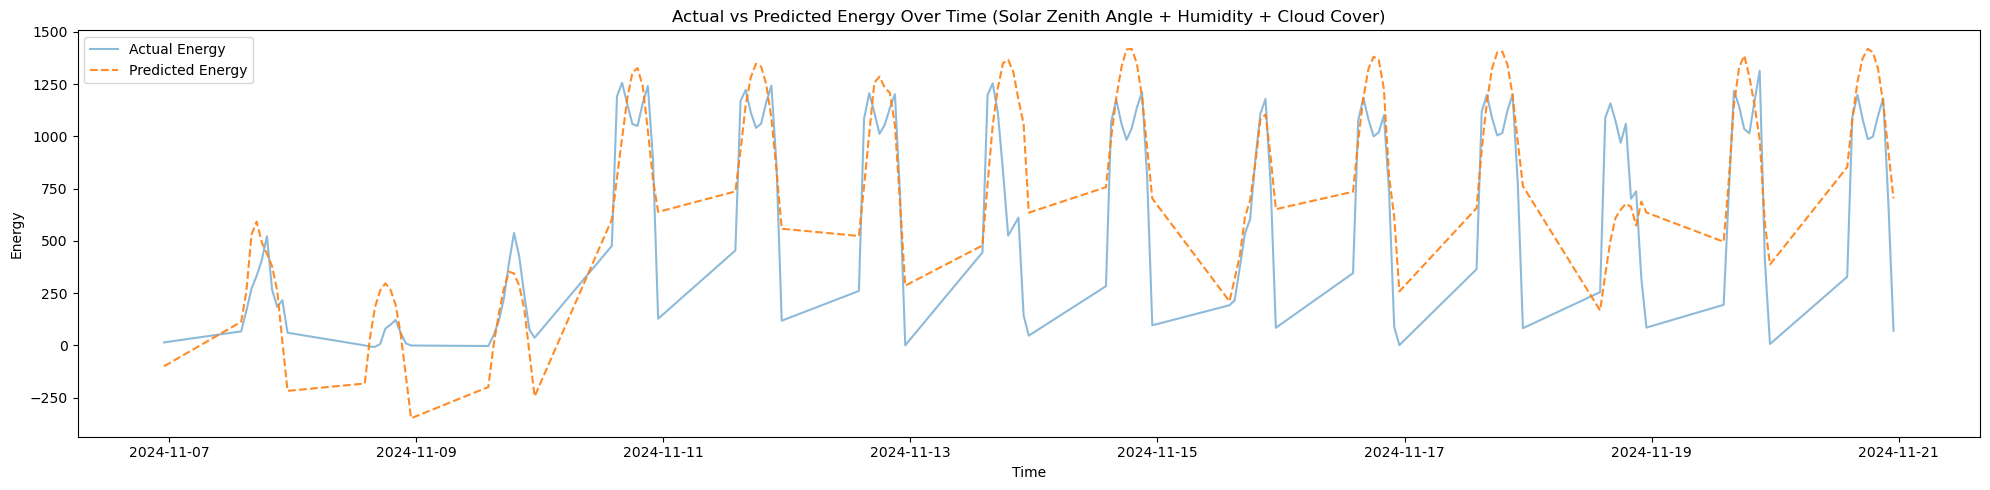

In [72]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_3.fit(X_3_22,y_3_22)

X_3_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc']]
y_3_24 = SolarDataDay24[['Energy']].copy()

y_3_24['Prediction'] = model_3.predict(X_3_24)

print('RMSE:',root_mean_squared_error(y_3_24.iloc[:,0],y_3_24.iloc[:,1]))
print('r2:',r2_score(y_3_24.iloc[:,0],y_3_24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(y_3_24.loc[random_start24:end_day24].index, y_3_24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(y_3_24.loc[random_start24:end_day24].index, y_3_24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Solar Zenith Angle + Humidity + Cloud Cover)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
model_4 = Pipeline(steps=[
    ('feature_change', ColumnTransformer(transformers=[('cos',FunctionTransformer(np.cos),['Solar Zenith Angle'])],remainder='passthrough')),
    ('regression', LinearRegression(n_jobs=-1))
])

X_4_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc']]
y_4_22 = SolarDataDay22['Energy']

dfx22 = X_4_22
dfy22 = y_4_22

print("Average RMSE:", -cross_val_score(model_4, dfx22, dfy22, cv=tscv, scoring='neg_root_mean_squared_error').mean())

print("Average r2:", cross_val_score(model_4, dfx22, dfy22, cv=tscv, scoring='r2').mean())

Average RMSE: 371.9999509169613
Average r2: 0.6295159745594182


RMSE: 378.4602943981863
r2: 0.6158912361901291


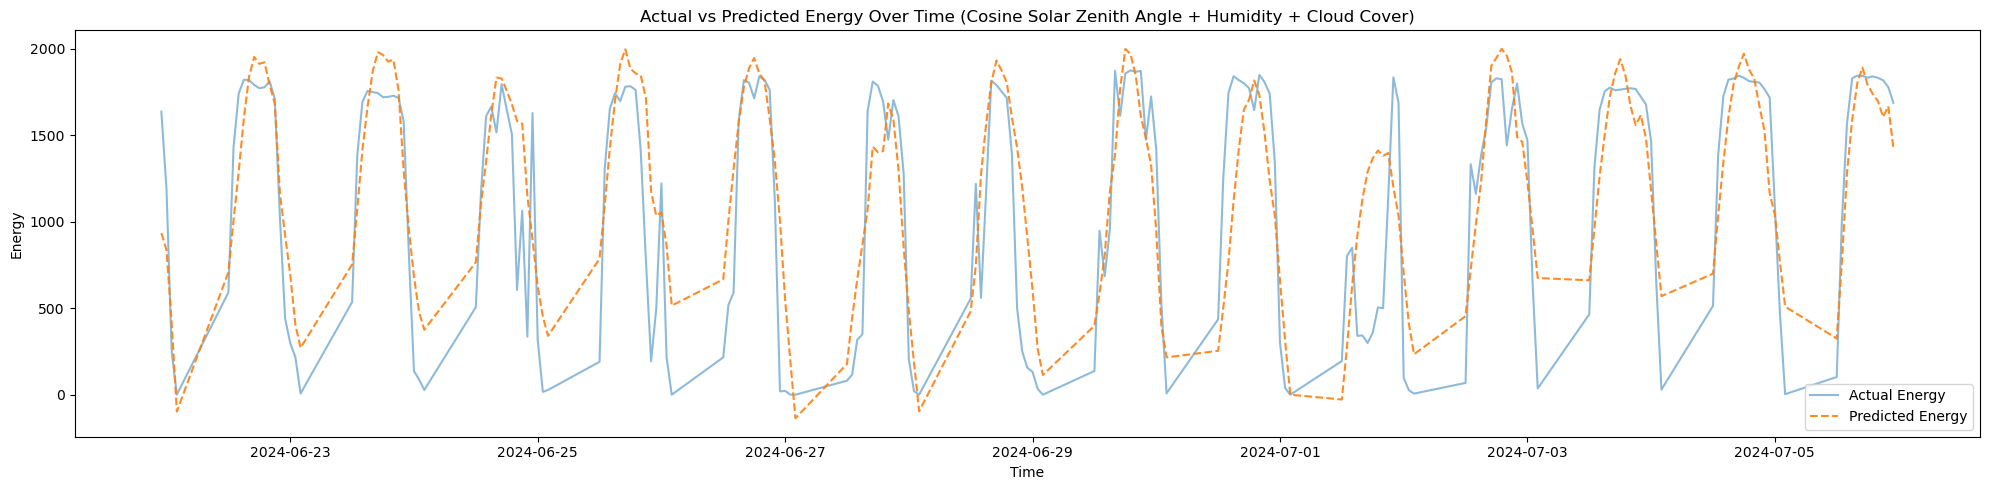

In [73]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_4.fit(X_4_22,y_4_22)

X_4_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc']]
y_4_24 = SolarDataDay24[['Energy']].copy()

dfx24 = X_4_24
dfy24 = y_4_24

dfy24['Prediction'] = model_4.predict(dfx24)

print('RMSE:',root_mean_squared_error(dfy24.iloc[:,0],dfy24.iloc[:,1]))
print('r2:',r2_score(dfy24.iloc[:,0],dfy24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Cosine Solar Zenith Angle + Humidity + Cloud Cover)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
model_5 = Pipeline(steps=[
    ('poly',PolynomialFeatures(degree=2,interaction_only=True)),
    ('regression', LinearRegression(n_jobs=-1))
])

X_5_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc']]
y_5_22 = SolarDataDay22['Energy']

dfx22 = X_5_22
dfy22 = y_5_22

print("Average RMSE:", -cross_val_score(model_5, dfx22, dfy22, cv=tscv, scoring='neg_root_mean_squared_error').mean())
print("Average r2:", cross_val_score(model_5, dfx22, dfy22, cv=tscv, scoring='r2').mean())


Average RMSE: 379.38319657474716
Average r2: 0.6155808800564827


RMSE: 380.8725006867409
r2: 0.6109792156645864


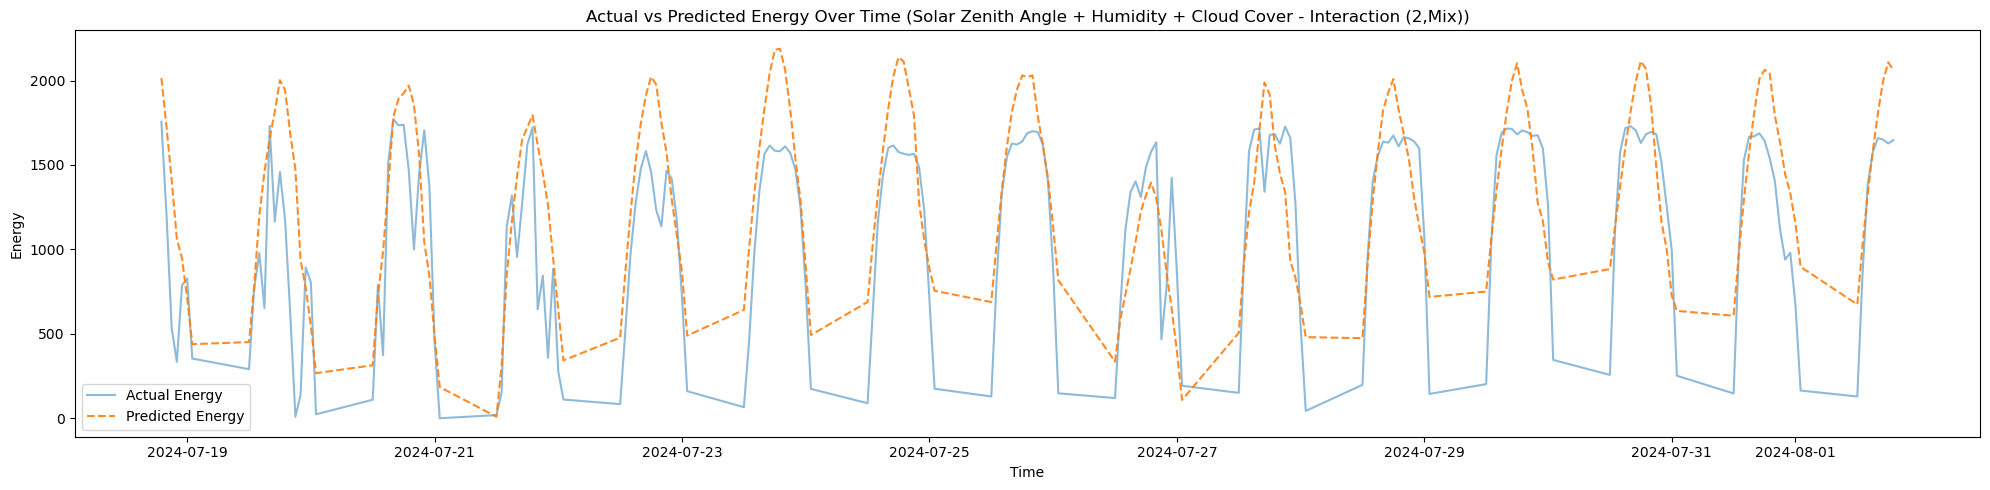

In [87]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_5.fit(dfx22,dfy22)

X_5_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc']]
y_5_24 = SolarDataDay24[['Energy']].copy()

dfx24 = X_5_24
dfy24 = y_5_24

dfy24['Prediction'] = np.clip(model_5.predict(dfx24),0,None)

print('RMSE:',root_mean_squared_error(dfy24.iloc[:,0],dfy24.iloc[:,1]))
print('r2:',r2_score(dfy24.iloc[:,0],dfy24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Solar Zenith Angle + Humidity + Cloud Cover - Interaction (2,Mix))")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
model_6 = Pipeline(steps=[
    ('feature_change', ColumnTransformer(transformers=[('cos',FunctionTransformer(np.cos),['Solar Zenith Angle'])],remainder='passthrough')),
    ('poly',PolynomialFeatures(degree=2,interaction_only=True)),
    ('regression', LinearRegression(n_jobs=-1))
])
X_6_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc']]
y_6_22 = SolarDataDay22['Energy']

dfx22 = X_6_22
dfy22 = y_6_22

print("Average RMSE:", -cross_val_score(model_6, dfx22, dfy22, cv=tscv, scoring='neg_root_mean_squared_error').mean())
print("Average r2:", cross_val_score(model_6, dfx22, dfy22, cv=tscv, scoring='r2').mean())

Average RMSE: 366.93432129600603
Average r2: 0.6405752052845642


RMSE: 373.3270137823213
r2: 0.6262403596058486


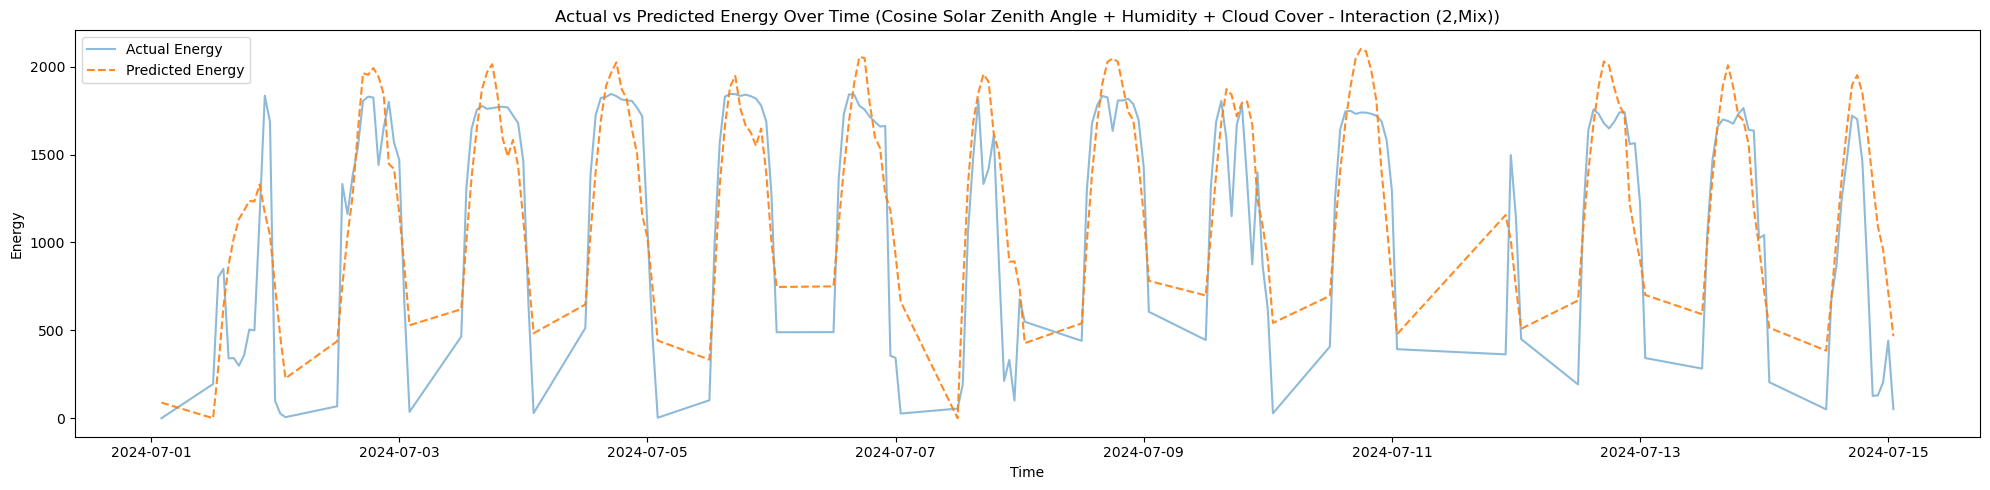

In [88]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_6.fit(dfx22,dfy22)

X_6_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc']]
y_6_24 = SolarDataDay24[['Energy']].copy()

dfx24 = X_6_24
dfy24 = y_6_24

dfy24['Prediction'] = np.clip(model_6.predict(dfx24),0,None)

print('RMSE:',root_mean_squared_error(dfy24.iloc[:,0],dfy24.iloc[:,1]))
print('r2:',r2_score(dfy24.iloc[:,0],dfy24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Cosine Solar Zenith Angle + Humidity + Cloud Cover - Interaction (2,Mix))")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
model_7 = Pipeline(steps=[
    ('poly',PolynomialFeatures(degree=2,interaction_only=False)),
    ('regression', LinearRegression(n_jobs=-1))
])

X_7_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc']]
y_7_22 = SolarDataDay22['Energy']

dfx22 = X_7_22
dfy22 = y_7_22

print("Average RMSE:", -cross_val_score(model_7, dfx22, dfy22, cv=tscv, scoring='neg_root_mean_squared_error').mean())
print("Average r2:", cross_val_score(model_7, dfx22, dfy22, cv=tscv, scoring='r2').mean())


Average RMSE: 358.03722748183253
Average r2: 0.6556586338419672


RMSE: 365.2970385947556
r2: 0.6421460022022456


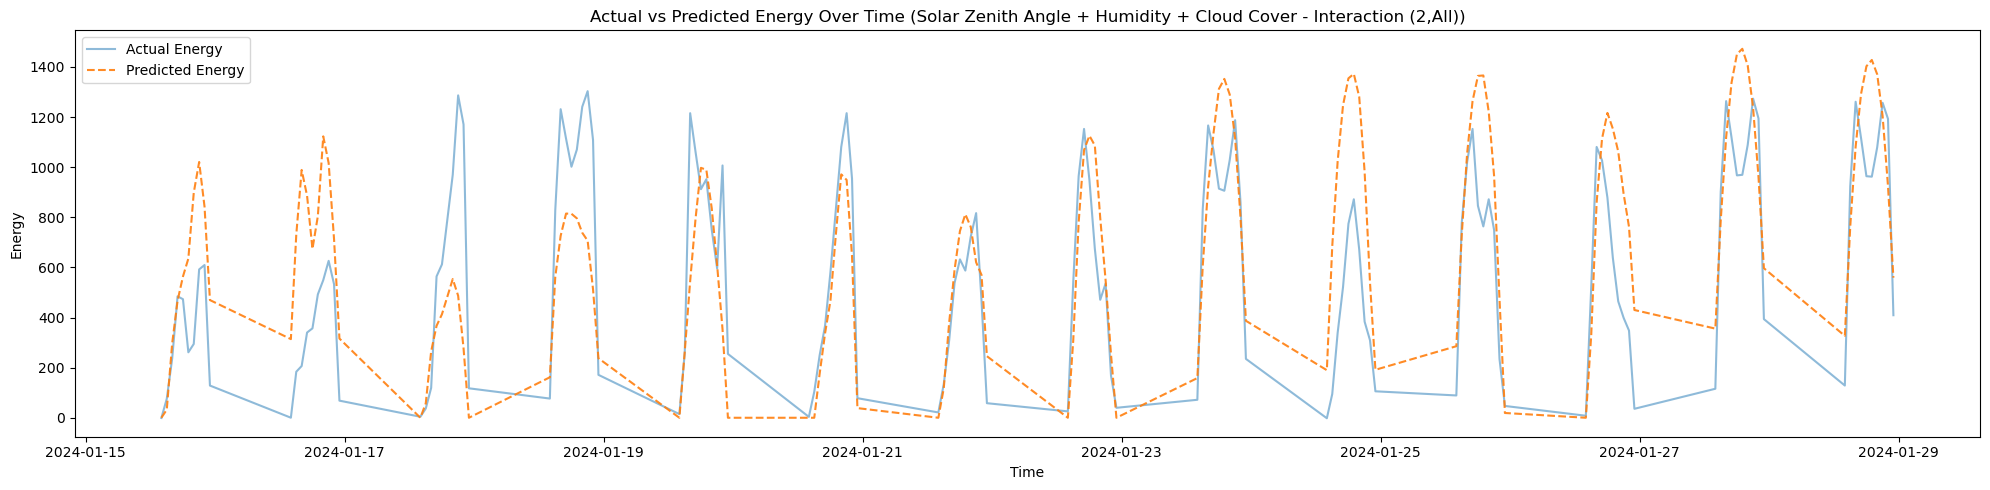

In [89]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_7.fit(dfx22,dfy22)

X_7_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc']]
y_7_24 = SolarDataDay24[['Energy']].copy()

dfx24 = X_7_24
dfy24 = y_7_24

dfy24['Prediction'] = np.clip(model_7.predict(dfx24),0,None)

print('RMSE:',root_mean_squared_error(dfy24.iloc[:,0],dfy24.iloc[:,1]))
print('r2:',r2_score(dfy24.iloc[:,0],dfy24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Solar Zenith Angle + Humidity + Cloud Cover - Interaction (2,All))")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
model_8 = Pipeline(steps=[
    ('feature_change', ColumnTransformer(transformers=[('cos',FunctionTransformer(np.cos),['Solar Zenith Angle'])],remainder='passthrough')),
    ('poly',PolynomialFeatures(degree=2,interaction_only=False)),
    ('regression', LinearRegression(n_jobs=-1))
])
X_8_22 = SolarDataDay22[['Solar Zenith Angle','Relative Humidity','tcc']]
y_8_22 = SolarDataDay22['Energy']

dfx22 = X_8_22
dfy22 = y_8_22

print("Average RMSE:", -cross_val_score(model_8, dfx22, dfy22, cv=tscv, scoring='neg_root_mean_squared_error').mean())
print("Average r2:", cross_val_score(model_8, dfx22, dfy22, cv=tscv, scoring='r2').mean())

Average RMSE: 353.34412270770457
Average r2: 0.6633484155402223


RMSE: 363.14919173842094
r2: 0.6463417983808734


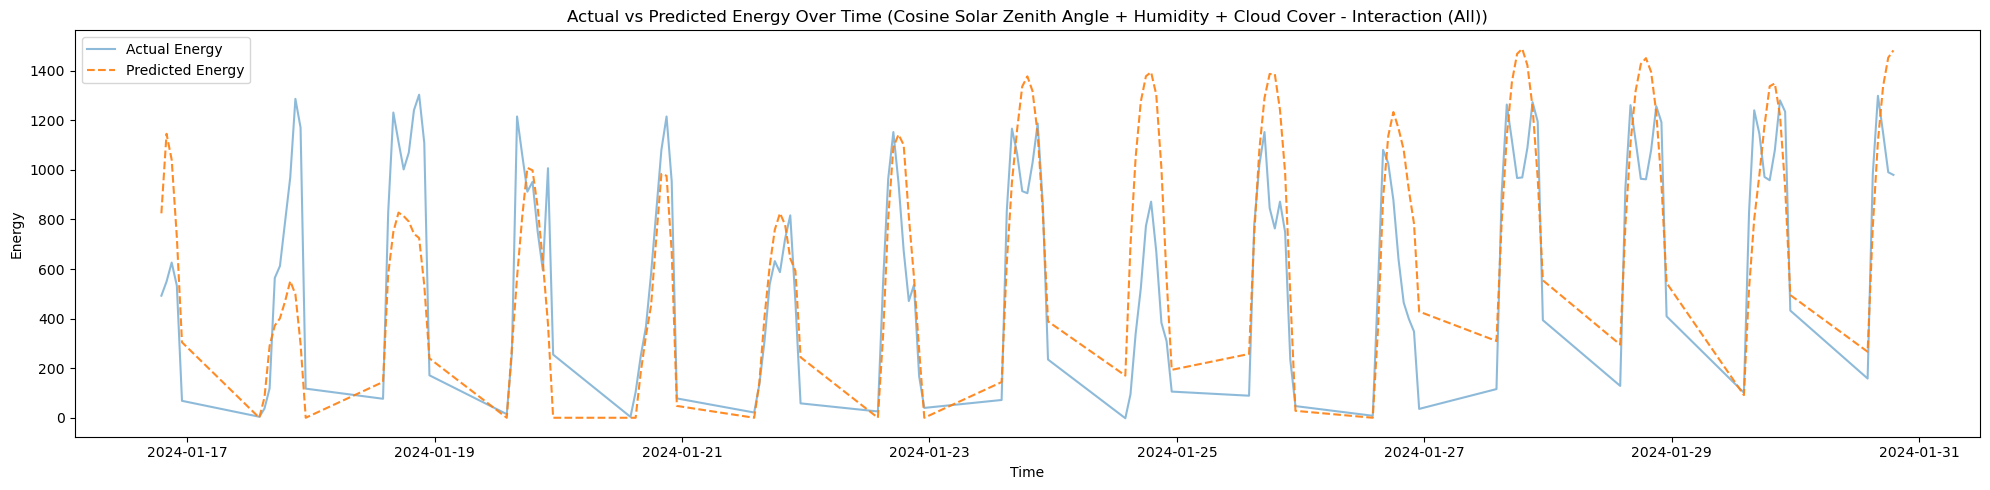

In [ ]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_8.fit(dfx22,dfy22)

X_8_24 = SolarDataDay24[['Solar Zenith Angle','Relative Humidity','tcc']]
y_8_24 = SolarDataDay24[['Energy']].copy()

dfx24 = X_8_24
dfy24 = y_8_24

dfy24['Prediction'] = np.clip(model_8.predict(dfx24),0,None)

print('RMSE:',root_mean_squared_error(dfy24.iloc[:,0],dfy24.iloc[:,1]))
print('r2:',r2_score(dfy24.iloc[:,0],dfy24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Cosine Solar Zenith Angle + Humidity + Cloud Cover - Interaction (2,All))")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [91]:
model_9 = Pipeline(steps=[
    ('poly',PolynomialFeatures(degree=2,interaction_only=True)),
    ('regression', LinearRegression(n_jobs=-1))
])
X_9_22 = SolarDataDay22[['Solar Zenith Angle','tcc']]
y_9_22 = SolarDataDay22['Energy']

dfx22 = X_9_22
dfy22 = y_9_22

print("Average RMSE:", -cross_val_score(model_9, dfx22, dfy22, cv=tscv, scoring='neg_root_mean_squared_error').mean())
print("Average r2:", cross_val_score(model_9, dfx22, dfy22, cv=tscv, scoring='r2').mean())

Average RMSE: 395.4726028063013
Average r2: 0.5825152410976557


RMSE: 393.17404338275327
r2: 0.5854439591656657


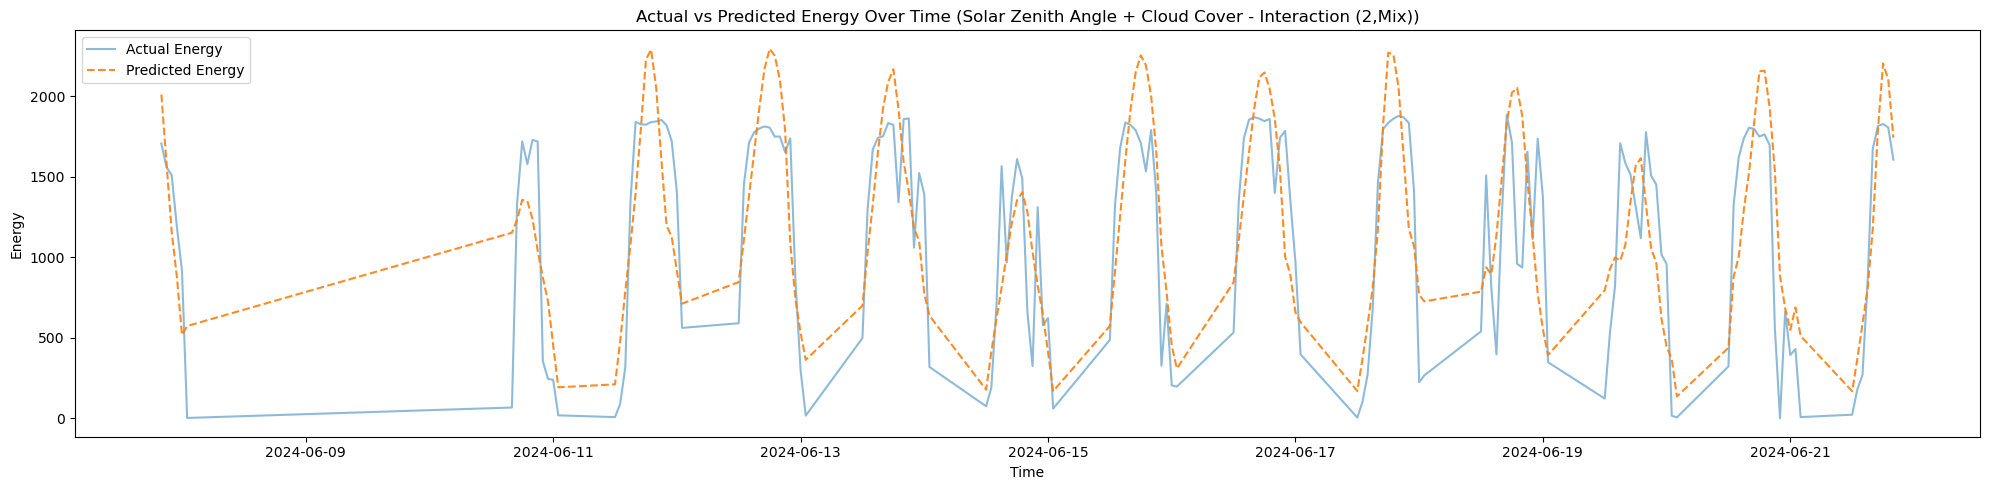

In [92]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_9.fit(dfx22,dfy22)

X_9_24 = SolarDataDay24[['Solar Zenith Angle','tcc']]
y_9_24 = SolarDataDay24[['Energy']].copy()

dfx24 = X_9_24
dfy24 = y_9_24

dfy24['Prediction'] = model_9.predict(dfx24)

print('RMSE:',root_mean_squared_error(dfy24.iloc[:,0],dfy24.iloc[:,1]))
print('r2:',r2_score(dfy24.iloc[:,0],dfy24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Solar Zenith Angle + Cloud Cover - Interaction (2,Mix))")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [94]:
model_10 = Pipeline(steps=[
    ('feature_change', ColumnTransformer(transformers=[('cos',FunctionTransformer(np.cos),['Solar Zenith Angle'])],remainder='passthrough')),
    ('poly',PolynomialFeatures(degree=3,interaction_only=True)),
    ('regression', LinearRegression(n_jobs=-1))
])
X_10_22 = SolarDataDay22[['Solar Zenith Angle','tcc','Relative Humidity']]
y_10_22 = SolarDataDay22['Energy']

dfx22 = X_10_22
dfy22 = y_10_22

print("Average RMSE:", -cross_val_score(model_10, dfx22, dfy22, cv=tscv, scoring='neg_root_mean_squared_error').mean())
print("Average r2:", cross_val_score(model_10, dfx22, dfy22, cv=tscv, scoring='r2').mean())

Average RMSE: 355.7802099508788
Average r2: 0.6604334478759799


RMSE: 366.42363536674543
r2: 0.6399353144831219


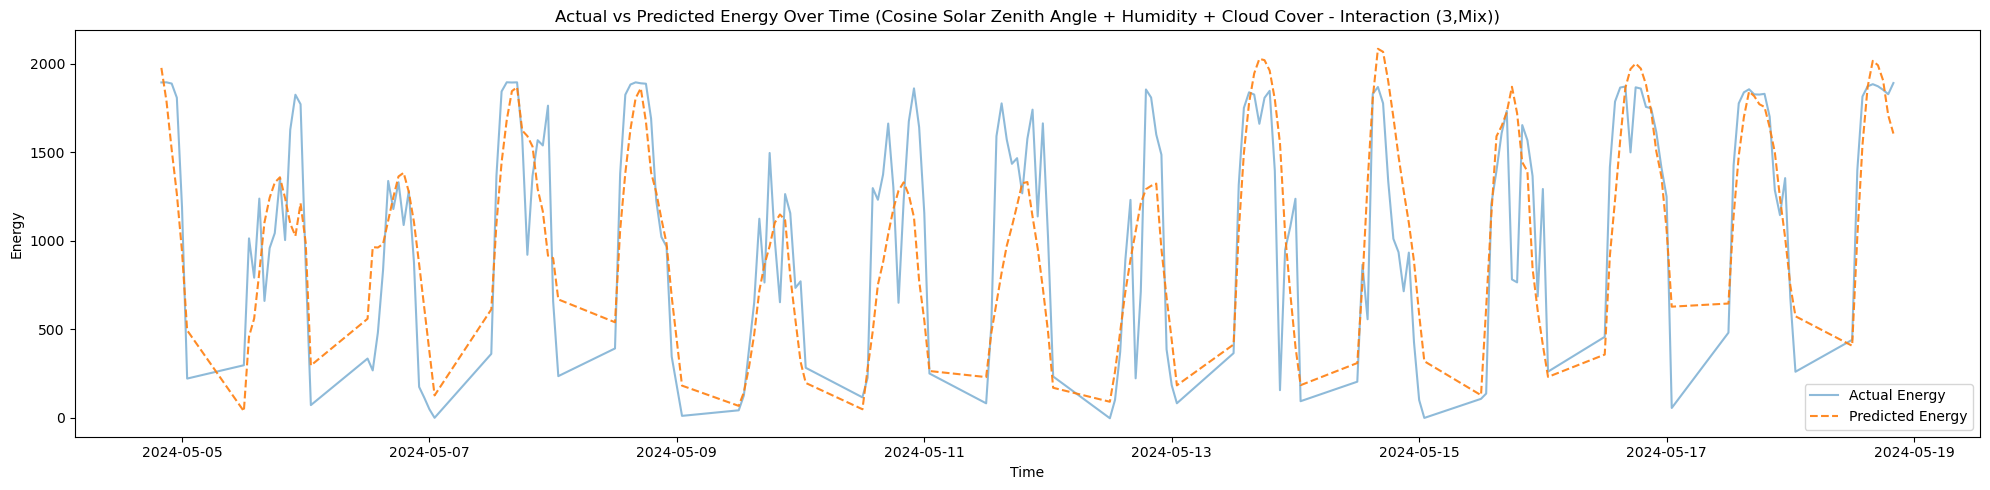

In [97]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_10.fit(dfx22,dfy22)

X_10_24 = SolarDataDay24[['Solar Zenith Angle','tcc','Relative Humidity']]
y_10_24 = SolarDataDay24[['Energy']].copy()

dfx24 = X_10_24
dfy24 = y_10_24

dfy24['Prediction'] = model_10.predict(dfx24)

print('RMSE:',root_mean_squared_error(dfy24.iloc[:,0],dfy24.iloc[:,1]))
print('r2:',r2_score(dfy24.iloc[:,0],dfy24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Cosine Solar Zenith Angle + Humidity + Cloud Cover - Interaction (3,Mix))")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [98]:
model_11 = Pipeline(steps=[
    ('feature_change', ColumnTransformer(transformers=[('cos',FunctionTransformer(np.cos),['Solar Zenith Angle'])],remainder='passthrough')),
    ('poly',PolynomialFeatures(degree=3,interaction_only=False)),
    ('regression', LinearRegression(n_jobs=-1))
])
X_11_22 = SolarDataDay22[['Solar Zenith Angle','tcc','Relative Humidity']]
y_11_22 = SolarDataDay22['Energy']

dfx22 = X_11_22
dfy22 = y_11_22

print("Average RMSE:", -cross_val_score(model_11, dfx22, dfy22, cv=tscv, scoring='neg_root_mean_squared_error').mean())
print("Average r2:", cross_val_score(model_11, dfx22, dfy22, cv=tscv, scoring='r2').mean())

Average RMSE: 354.8286966881068
Average r2: 0.6550076839301446


RMSE: 359.2040040349134
r2: 0.6539842172977198


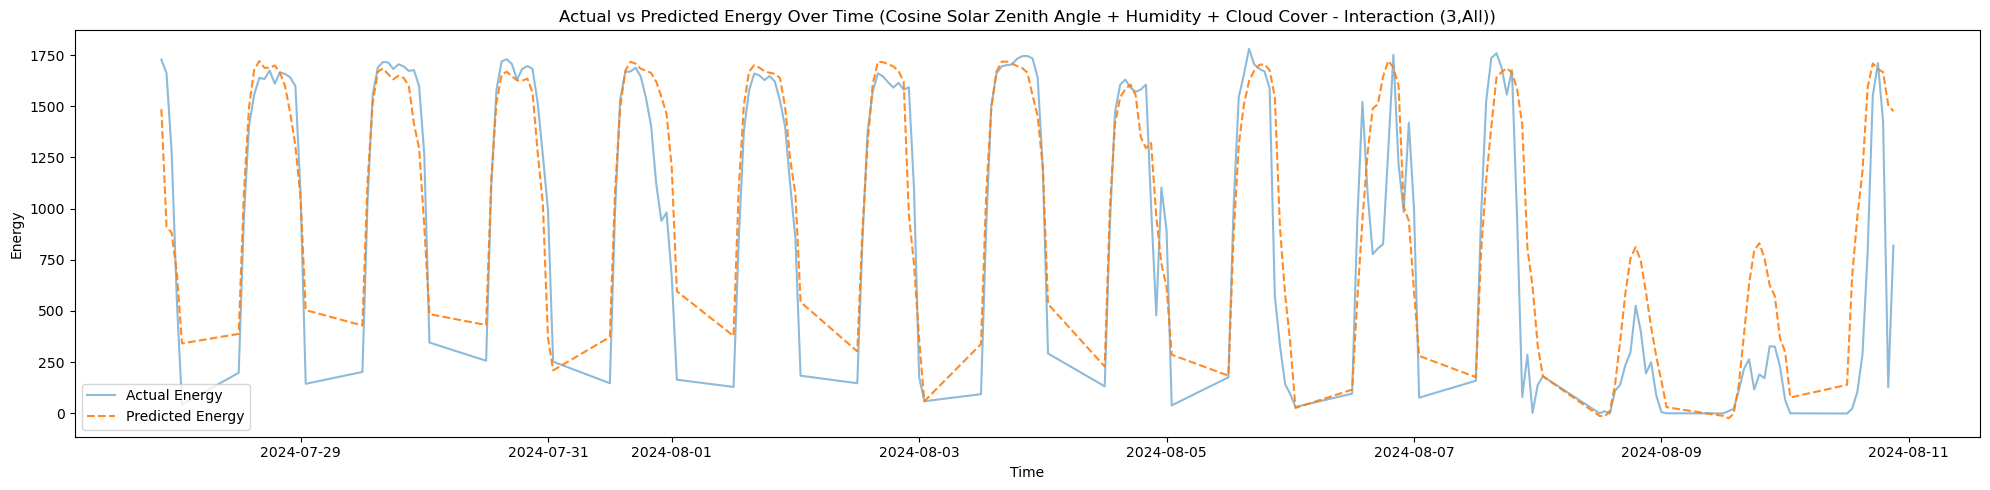

In [99]:
days24 = SolarData24.index.unique()
random_start24 = np.random.choice(days24)
end_day24 = random_start24+pd.Timedelta(days=14)

model_11.fit(dfx22,dfy22)

X_11_24 = SolarDataDay24[['Solar Zenith Angle','tcc','Relative Humidity']]
y_11_24 = SolarDataDay24[['Energy']].copy()

dfx24 = X_11_24
dfy24 = y_11_24

dfy24['Prediction'] = model_11.predict(dfx24)

print('RMSE:',root_mean_squared_error(dfy24.iloc[:,0],dfy24.iloc[:,1]))
print('r2:',r2_score(dfy24.iloc[:,0],dfy24.iloc[:,1]))

plt.figure(figsize=(20, 5))
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Energy'], label='Actual Energy', alpha=0.5)
plt.plot(dfy24.loc[random_start24:end_day24].index, dfy24[random_start24:end_day24]['Prediction'], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time (Cosine Solar Zenith Angle + Humidity + Cloud Cover - Interaction (3,All))")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()